In [10]:
% matplotlib inline

import sys

sys.path.insert(0, "..")

import time
import pandas as pd

from IPython import display as d

import numpy as np

import seaborn as sns
sns.set()

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from libs import container
from libs.experiment import (
    WithAnotherExperiment, KFoldExperiment, roc, 
    discretize_classes, clean_features)

import pytff


from libs import fourier_help

from matplotlib import pyplot as plt
from matplotlib import cm
import seaborn as sns
sns.set()

plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
path = "/home/data/carpyncho/stored/samples/smp_2500_rrVSunk/"
data = container.read(path)
_, classes, sclasses = discretize_classes(data)
df = data.b278

ogle3 = pd.read_table("/home/jbcabral/projects/paper_b278/src/legacy/data/ogle_rr.txt", header=6)
ogle3.columns

tile = pd.DataFrame(np.load("/home/data/carpyncho/stored/npy_tiles/cat_b278_jhk_1.npy"))

def get_o3id(o3id):
    return ogle3[ogle3["# ID"] == o3id].A_1.values[0]
    
df = df[df.scls == 3].copy()
df["ogle3_id"] = df.id.apply(lambda cid: tile[tile.id == cid].ogle3_id.values[0])
df["ogle3_A"] = df.ogle3_id.apply(get_o3id)
df["Feat A vs Feat. Fourier A0"] = np.abs(df.Amplitude - df.Freq1_harmonics_amplitude_0)
df["Feat A vs OGLE3 A_1"] = np.abs(df.Amplitude - df.ogle3_A)
df["Feat Fourier A0 vs OGLE3 A_1"] = np.abs(df.ogle3_A - df.Freq1_harmonics_amplitude_0)

obs = pd.read_pickle("/home/jbcabral/projects/paper_b278/src/legacy/data/rrb278_obs.pkl")

Loading '/home/data/carpyncho/stored/samples/smp_2500_rrVSunk/b261.npy'...
Loading '/home/data/carpyncho/stored/samples/smp_2500_rrVSunk/b263.npy'...
Loading '/home/data/carpyncho/stored/samples/smp_2500_rrVSunk/b264.npy'...
Loading '/home/data/carpyncho/stored/samples/smp_2500_rrVSunk/b262.npy'...
Loading '/home/data/carpyncho/stored/samples/smp_2500_rrVSunk/b278.npy'...


/home/jbcabral/projects/paper_b278/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
columns = [
    'Feat A vs Feat. Fourier A0', 
    'Feat A vs OGLE3 A_1', 
    'Feat Fourier A0 vs OGLE3 A_1']

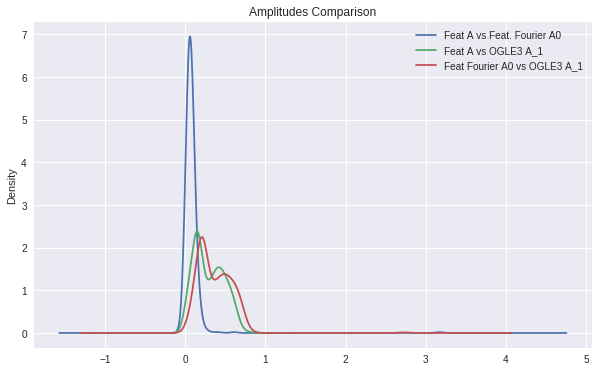

In [14]:
df[columns].plot.kde(title="Amplitudes Comparison");

In [5]:
df.sample(3)

,id,ogle3_type,cnt,Amplitude,AndersonDarling,Autocor_length,Beyond1Std,CAR_mean,CAR_sigma,CAR_tau,...,n09_jh_color,cls,real_cls,scls,real_scls,ogle3_id,ogle3_A,Feat A vs Feat. Fourier A0,Feat A vs OGLE3 A_1,Feat Fourier A0 vs OGLE3 A_1
1665,32780000301030,RRLyr-RRab,114,0.16475,1.000000,2.0,0.271930,51.269176,-0.212794,0.276830,...,0.242207,6,6,3,3,OGLE-BLG-RRLYR-11814,0.361,0.051384,0.19625,0.247634
1036,32780000196148,RRLyr-RRc,114,0.09375,0.992690,1.0,0.315789,53.775062,0.090912,0.268914,...,0.061352,7,7,3,3,OGLE-BLG-RRLYR-11862,0.273,0.049164,0.17925,0.228414
2462,32780000422213,RRLyr-RRc,57,0.09000,0.417267,1.0,0.315789,28.328045,0.048319,0.517355,...,0.268907,7,7,3,3,OGLE-BLG-RRLYR-13580,0.256,0.042071,0.16600,0.208071


In [6]:
tile["c89_ejk_vvv"] = tile["c89_aj_vvv"] - tile["c89_ak_vvv"]
tile["n09_ejk_vvv"] = tile["n09_aj_vvv"] - tile["n09_ak_vvv"]

In [7]:
import math
def amplitude(magnitude):
    N = len(magnitude)
    sorted_mag = np.sort(magnitude)

    amplitude = (np.median(sorted_mag[-int(math.ceil(0.05 * N)):]) -
                 np.median(sorted_mag[0:int(math.ceil(0.05 * N))])) / 2.0
    return amplitude

def get_unred_light_curve_A(id, paper):
    ejk_key = "{}_ejk_vvv".format(paper)
    ejk = tile[tile.id==id][ejk_key].values[0]
    lc = obs[obs.bm_src_id == id]
    mags = lc.pwp_stack_src_mag3.values - ejk
    return amplitude(mags)
    

df["c89_unredening_lc_amp"] = df.id.apply(lambda i: get_unred_light_curve_A(i, "c89"))
df["n09_unredening_lc_amp"] = df.id.apply(lambda i: get_unred_light_curve_A(i, "n09"))

In [15]:
df[["Amplitude", "c89_unredening_lc_amp", "n09_unredening_lc_amp"]].describe()

,Amplitude,c89_unredening_lc_amp,n09_unredening_lc_amp
count,426.000000,426.000000,426.000000
mean,0.157313,0.157313,0.157313
std,0.069663,0.069663,0.069663
min,0.028250,0.028250,0.028250
25%,0.110000,0.110000,0.110000
50%,0.155875,0.155875,0.155875
75%,0.184750,0.184750,0.184750
max,0.756750,0.756750,0.756750


In [27]:
def get_unred_A(ia, paper):
    ejk_key = "{}_ejk_vvv".format(paper)
    ejk = tile[tile.id==ia.id][ejk_key].values[0]
    return ia.Amplitude - np.abs(ejk)
    

df["c89_unredening_amp"] = df[["id", "Amplitude"]].apply(lambda ia: get_unred_A(ia, "c89"), axis=1)
df["n09_unredening_amp"] = df[["id", "Amplitude"]].apply(lambda ia: get_unred_A(ia, "n09"), axis=1)

In [28]:
df[["Amplitude", "c89_unredening_amp", "n09_unredening_amp"]].describe()

,Amplitude,c89_unredening_amp,n09_unredening_amp
count,426.000000,426.000000,426.000000
mean,0.157313,-0.104097,-0.102762
std,0.069663,0.087305,0.087100
min,0.028250,-0.371984,-0.369652
25%,0.110000,-0.156771,-0.155226
50%,0.155875,-0.108739,-0.107417
75%,0.184750,-0.049023,-0.047943
max,0.756750,0.499841,0.500823
